In [91]:
import requests
import config
from bs4 import BeautifulSoup as BS
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np

In [2]:
cnx = mysql.connector.connect(
  host=config.hostj,
  user=config.userj,
  passwd=config.pwj,
  database = 'nfl_draft_info')

cursor = cnx.cursor()

In [101]:
df_joined = pd.read_csv('df_joined.csv')
df_joined = df_joined.set_index('id')
df_joined = df_joined.drop(df_joined.columns[0], axis=1)

In [102]:
df_joined.head()

,name,contract_years,total_value,gtd_start,gtd_total,year,position,height,weight,forty,vertical,bench,broad_jump,three_cone,shuttle,pick_number
id,,,,,,,,,,,,,,,,
11,Nelson Agholor,4,9377374,8520507,8520507,2015,WR,72,198,4.42,NaN,12.0,NaN,NaN,NaN,20.0
10,Arik Armstead,4,9842630,9842630,9842630,2015,DE,79,292,5.06,34.0,24.0,117.0,7.57,4.53,17.0
6,Vic Beasley,4,14495228,14495228,14495228,2015,OLB,75,246,4.53,41.0,35.0,130.0,6.91,4.15,8.0
3,Amari Cooper,4,22663116,22663116,22663116,2015,WR,73,211,4.42,33.0,NaN,120.0,6.71,3.98,4.0
9,Melvin Gordon,4,10669773,10669773,10669773,2015,RB,73,215,4.52,35.0,19.0,126.0,7.04,4.07,15.0


In [103]:
df_joined['position'].unique()

array(['WR', 'DE', 'OLB', 'RB', 'OT', 'CB', 'QB', 'FS', 'DT', 'C', 'P',
       'TE', 'SS', 'ILB', 'OG', 'EDGE', 'S', 'FB', 'LB', 'DB', 'OL', 'DL',
       'K'], dtype=object)

In [104]:
position_groups = {'WR': 'BK', 'DE': 'DL', 'OLB': 'LB', 'RB': 'BK', 'OT': 'OL', 'CB': 'BK', 'QB': 'ST',
                  'FS': 'BK', 'DT': 'DL', 'C': 'OL', 'P': 'ST', 'TE': 'BK', 'SS': 'BK', 'ILB': 'LB', 'OG': 'OL',
                  'EDGE': 'LB', 'S': 'BK', 'FB': 'BK', 'LB': 'LB', 'DB': 'BK', 'OL': 'OL', 'DL': 'DL',
                  'K': 'ST'}

In [105]:
df_joined['pos_grp'] = df_joined['position'].map(position_groups)

In [106]:
df_joined.head(50)

,name,contract_years,total_value,gtd_start,gtd_total,year,position,height,weight,forty,vertical,bench,broad_jump,three_cone,shuttle,pick_number,pos_grp
id,,,,,,,,,,,,,,,,,
11,Nelson Agholor,4,9377374,8520507,8520507,2015,WR,72,198,4.42,NaN,12.0,NaN,NaN,NaN,20.0,BK
10,Arik Armstead,4,9842630,9842630,9842630,2015,DE,79,292,5.06,34.0,24.0,117.0,7.57,4.53,17.0,DL
6,Vic Beasley,4,14495228,14495228,14495228,2015,OLB,75,246,4.53,41.0,35.0,130.0,6.91,4.15,8.0,LB
3,Amari Cooper,4,22663116,22663116,22663116,2015,WR,73,211,4.42,33.0,NaN,120.0,6.71,3.98,4.0,BK
9,Melvin Gordon,4,10669773,10669773,10669773,2015,RB,73,215,4.52,35.0,19.0,126.0,7.04,4.07,15.0,BK
13,D.J. Humphries,4,8912112,7261824,7261824,2015,OT,77,307,5.12,31.0,26.0,104.0,7.87,4.64,24.0,OL
14,Byron Jones,4,8601941,6993950,6993950,2015,CB,73,199,4.43,44.5,NaN,147.0,6.78,3.94,27.0,BK
2,Marcus Mariota,4,24213974,24213974,24213974,2015,QB,76,222,4.52,36.0,NaN,121.0,6.87,4.11,2.0,ST
8,Andrus Peat,4,11393496,11393496,11393496,2015,OT,79,313,5.18,31.0,NaN,105.0,8.01,4.62,13.0,OL


In [107]:
cols = df_joined.columns.tolist()

In [108]:
cols = cols[:4] + cols[-1:] + cols[4:-1]

In [109]:
cols.pop(7)

'position'

In [127]:
cols

['name',
 'contract_years',
 'total_value',
 'gtd_start',
 'pos_grp',
 'gtd_total',
 'year',
 'height',
 'weight',
 'forty',
 'vertical',
 'bench',
 'broad_jump',
 'three_cone',
 'shuttle',
 'pick_number']

In [111]:
df_joined = df_joined[cols]

In [112]:
df_joined.head()

,name,contract_years,total_value,gtd_start,pos_grp,gtd_total,year,height,weight,forty,vertical,bench,broad_jump,three_cone,shuttle,pick_number
id,,,,,,,,,,,,,,,,
11,Nelson Agholor,4,9377374,8520507,BK,8520507,2015,72,198,4.42,NaN,12.0,NaN,NaN,NaN,20.0
10,Arik Armstead,4,9842630,9842630,DL,9842630,2015,79,292,5.06,34.0,24.0,117.0,7.57,4.53,17.0
6,Vic Beasley,4,14495228,14495228,LB,14495228,2015,75,246,4.53,41.0,35.0,130.0,6.91,4.15,8.0
3,Amari Cooper,4,22663116,22663116,BK,22663116,2015,73,211,4.42,33.0,NaN,120.0,6.71,3.98,4.0
9,Melvin Gordon,4,10669773,10669773,BK,10669773,2015,73,215,4.52,35.0,19.0,126.0,7.04,4.07,15.0


In [115]:
df_joined2 = df_joined[(df_joined['pos_grp'] != 'ST')]
df_joined2.head(30)

,name,contract_years,total_value,gtd_start,pos_grp,gtd_total,year,height,weight,forty,vertical,bench,broad_jump,three_cone,shuttle,pick_number
id,,,,,,,,,,,,,,,,
11,Nelson Agholor,4,9377374,8520507,BK,8520507,2015,72,198,4.42,NaN,12.0,NaN,NaN,NaN,20.0
10,Arik Armstead,4,9842630,9842630,DL,9842630,2015,79,292,5.06,34.0,24.0,117.0,7.57,4.53,17.0
6,Vic Beasley,4,14495228,14495228,LB,14495228,2015,75,246,4.53,41.0,35.0,130.0,6.91,4.15,8.0
3,Amari Cooper,4,22663116,22663116,BK,22663116,2015,73,211,4.42,33.0,NaN,120.0,6.71,3.98,4.0
9,Melvin Gordon,4,10669773,10669773,BK,10669773,2015,73,215,4.52,35.0,19.0,126.0,7.04,4.07,15.0
13,D.J. Humphries,4,8912112,7261824,OL,7261824,2015,77,307,5.12,31.0,26.0,104.0,7.87,4.64,24.0
14,Byron Jones,4,8601941,6993950,BK,6993950,2015,73,199,4.43,44.5,NaN,147.0,6.78,3.94,27.0
8,Andrus Peat,4,11393496,11393496,OL,11393496,2015,79,313,5.18,31.0,NaN,105.0,8.01,4.62,13.0
15,Damarious Randall,4,7915734,5966315,BK,5966315,2015,71,196,4.46,38.0,14.0,120.0,6.83,4.07,30.0


In [118]:
position_dummy = pd.get_dummies(df_joined2['pos_grp'],prefix = 'position', drop_first=True)

In [119]:
position_dummy.head(50)

,position_DL,position_LB,position_OL
id,,,
11,0,0,0
10,1,0,0
6,0,1,0
3,0,0,0
9,0,0,0
13,0,0,1
14,0,0,0
8,0,0,1
15,0,0,0


In [120]:
df_joined2[['pos_grp']]

,pos_grp
id,
11,BK
10,DL
6,LB
3,BK
9,BK
...,...
793,BK
592,LB
640,DL


In [128]:
df_joined2['avg_salary'] = df_joined2.apply(lambda row: row['total_value']/row['contract_years'], axis=1)

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [130]:
df_joined2['log_salary'] = df_joined2.apply(lambda row: np.log(row['avg_salary']), axis =1)

/Users/andrewtriola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
df_with_dummies = pd.concat([df_joined2, position_dummy], axis = 1)

In [133]:
df_with_dummies.head()

,name,contract_years,total_value,gtd_start,pos_grp,gtd_total,year,height,weight,forty,...,bench,broad_jump,three_cone,shuttle,pick_number,avg_salary,log_salary,position_DL,position_LB,position_OL
id,,,,,,,,,,,,,,,,,,,,,
11,Nelson Agholor,4,9377374,8520507,BK,8520507,2015,72,198,4.42,...,12.0,NaN,NaN,NaN,20.0,2344343.50,14.667516,0,0,0
10,Arik Armstead,4,9842630,9842630,DL,9842630,2015,79,292,5.06,...,24.0,117.0,7.57,4.53,17.0,2460657.50,14.715939,1,0,0
6,Vic Beasley,4,14495228,14495228,LB,14495228,2015,75,246,4.53,...,35.0,130.0,6.91,4.15,8.0,3623807.00,15.103036,0,1,0
3,Amari Cooper,4,22663116,22663116,BK,22663116,2015,73,211,4.42,...,NaN,120.0,6.71,3.98,4.0,5665779.00,15.549955,0,0,0
9,Melvin Gordon,4,10669773,10669773,BK,10669773,2015,73,215,4.52,...,19.0,126.0,7.04,4.07,15.0,2667443.25,14.796631,0,0,0


In [289]:
val_reg_pos = ols('log_salary~shuttle+bench+forty+position_DL+position_LB+position_OL', data=df_with_dummies).fit()
val_reg_pos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     9.788
Date:                Thu, 16 Jan 2020   Prob (F-statistic):           6.32e-10
Time:                        14:33:17   Log-Likelihood:                -285.40
No. Observations:                 334   AIC:                             584.8
Df Residuals:                     327   BIC:                             611.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.5727      1.033     19.918      0.000      18.541      22.605
shuttle        -0.4103      0.215     -1.911      0.057      -0.833       0.012
bench           0.0140      0.007      1.960      0.051   -5.08e-05       0.028
forty          -1.1534      0.227     -5.073      0.000      -1.601      -0.706
position_DL     0.7396      0.145      5.102      0.000       0.454       1.025
position_LB     0.1218      0.106      1.148      0.252      -0.087       0.331
position_OL     0.8736      0.173      5.045      0.000       0.533       1.214
==============================================================================
Omnibus:                       39.922   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.335
Skew:                           0.953   Prob(JB):                     7.12e-12
Kurtosis:                       3.238   Cond. No.                         757.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
df_with_dummies.columns

Index(['name', 'contract_years', 'total_value', 'gtd_start', 'pos_grp',
       'gtd_total', 'year', 'height', 'weight', 'forty', 'vertical', 'bench',
       'broad_jump', 'three_cone', 'shuttle', 'pick_number', 'avg_salary',
       'log_salary', 'position_DL', 'position_LB', 'position_OL'],
      dtype='object')

In [156]:
df_with_dummies['if_gtd'] = np.where(df_with_dummies['gtd_total']==0, 'no', 'yes')

In [157]:
df_with_dummies.head()

,name,contract_years,total_value,gtd_start,pos_grp,gtd_total,year,height,weight,forty,...,broad_jump,three_cone,shuttle,pick_number,avg_salary,log_salary,position_DL,position_LB,position_OL,if_gtd
id,,,,,,,,,,,,,,,,,,,,,
11,Nelson Agholor,4,9377374,8520507,BK,8520507,2015,72,198,4.42,...,NaN,NaN,NaN,20.0,2344343.50,14.667516,0,0,0,yes
10,Arik Armstead,4,9842630,9842630,DL,9842630,2015,79,292,5.06,...,117.0,7.57,4.53,17.0,2460657.50,14.715939,1,0,0,yes
6,Vic Beasley,4,14495228,14495228,LB,14495228,2015,75,246,4.53,...,130.0,6.91,4.15,8.0,3623807.00,15.103036,0,1,0,yes
3,Amari Cooper,4,22663116,22663116,BK,22663116,2015,73,211,4.42,...,120.0,6.71,3.98,4.0,5665779.00,15.549955,0,0,0,yes
9,Melvin Gordon,4,10669773,10669773,BK,10669773,2015,73,215,4.52,...,126.0,7.04,4.07,15.0,2667443.25,14.796631,0,0,0,yes


In [160]:
gtd_dummy = pd.get_dummies(df_with_dummies['if_gtd'],prefix = 'gtd', drop_first=True)

In [161]:
gtd_dummy

,gtd_yes
id,
11,1
10,1
6,1
3,1
9,1
...,...
793,1
592,1
640,1


In [162]:
df2_with_dummies = pd.concat([df_with_dummies, gtd_dummy], axis = 1)

In [163]:
df2_with_dummies.head()

,name,contract_years,total_value,gtd_start,pos_grp,gtd_total,year,height,weight,forty,...,three_cone,shuttle,pick_number,avg_salary,log_salary,position_DL,position_LB,position_OL,if_gtd,gtd_yes
id,,,,,,,,,,,,,,,,,,,,,
11,Nelson Agholor,4,9377374,8520507,BK,8520507,2015,72,198,4.42,...,NaN,NaN,20.0,2344343.50,14.667516,0,0,0,yes,1
10,Arik Armstead,4,9842630,9842630,DL,9842630,2015,79,292,5.06,...,7.57,4.53,17.0,2460657.50,14.715939,1,0,0,yes,1
6,Vic Beasley,4,14495228,14495228,LB,14495228,2015,75,246,4.53,...,6.91,4.15,8.0,3623807.00,15.103036,0,1,0,yes,1
3,Amari Cooper,4,22663116,22663116,BK,22663116,2015,73,211,4.42,...,6.71,3.98,4.0,5665779.00,15.549955,0,0,0,yes,1
9,Melvin Gordon,4,10669773,10669773,BK,10669773,2015,73,215,4.52,...,7.04,4.07,15.0,2667443.25,14.796631,0,0,0,yes,1


In [194]:
log_reg_ = ols('log_salary~forty+shuttle+bench+position_DL+position_LB+position_OL', data=df_with_dummies).fit()
log_reg_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     9.788
Date:                Thu, 16 Jan 2020   Prob (F-statistic):           6.32e-10
Time:                        10:25:36   Log-Likelihood:                -285.40
No. Observations:                 334   AIC:                             584.8
Df Residuals:                     327   BIC:                             611.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.5727      1.033     19.918      0.000      18.541      22.605
forty          -1.1534      0.227     -5.073      0.000      -1.601      -0.706
shuttle        -0.4103      0.215     -1.911      0.057      -0.833       0.012
bench           0.0140      0.007      1.960      0.051   -5.08e-05       0.028
position_DL     0.7396      0.145      5.102      0.000       0.454       1.025
position_LB     0.1218      0.106      1.148      0.252      -0.087       0.331
position_OL     0.8736      0.173      5.045      0.000       0.533       1.214
==============================================================================
Omnibus:                       39.922   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.335
Skew:                           0.953   Prob(JB):                     7.12e-12
Kurtosis:                       3.238   Cond. No.                         757.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
###create df with no outliers
#df_no_outliers = 

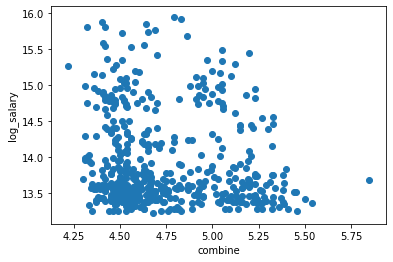

In [209]:
plt.scatter(df_with_dummies['forty'],df_with_dummies['log_salary'])
plt.xlabel('combine')
plt.ylabel('log_salary')
plt.show()

In [212]:
df_with_dummies.columns

Index(['name', 'contract_years', 'total_value', 'gtd_start', 'pos_grp',
       'gtd_total', 'year', 'height', 'weight', 'forty', 'vertical', 'bench',
       'broad_jump', 'three_cone', 'shuttle', 'pick_number', 'avg_salary',
       'log_salary', 'position_DL', 'position_LB', 'position_OL', 'if_gtd'],
      dtype='object')

In [239]:
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 11 to 549
Data columns (total 22 columns):
name              620 non-null object
contract_years    620 non-null int64
total_value       620 non-null int64
gtd_start         620 non-null int64
pos_grp           620 non-null object
gtd_total         620 non-null int64
year              620 non-null int64
height            620 non-null int64
weight            620 non-null int64
forty             523 non-null float64
vertical          504 non-null float64
bench             494 non-null float64
broad_jump        501 non-null float64
three_cone        392 non-null float64
shuttle           406 non-null float64
pick_number       549 non-null float64
avg_salary        620 non-null float64
log_salary        620 non-null float64
position_DL       620 non-null uint8
position_LB       620 non-null uint8
position_OL       620 non-null uint8
if_gtd            620 non-null object
dtypes: float64(9), int64(7), object(3), uint8(3)
memory us

In [301]:
df_shuttle = df_with_dummies[["log_salary", "weight", "forty", "bench", "shuttle", "position_LB", "position_OL", "position_DL"]]

In [306]:
df_no_null = df_shuttle.dropna()

In [307]:
# implementation 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = df_no_null


y = data[["log_salary"]]
X = data[["weight", "forty", "bench", "shuttle", "position_LB", "position_OL", "position_DL"]]

scale = MinMaxScaler()
transformed = scale.fit_transform(X)
X = pd.DataFrame(transformed, columns = X.columns)

In [308]:
# Perform t`est train split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Build a Ridge, Lasso and regular linear regression model. 
# Note how in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)

lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [240]:
#### train-test-split with no null values


In [292]:
from sklearn.neighbors import KNeighborsRegressor

In [296]:
def fill_missing_shuttle(row, neigh):
    if np.isnan(row['shuttle']):
        if np.isnan(row['forty']):
            #print(row['shuttle'])
            return row['shuttle']
        else:
            return neigh.predict([[row['weight'],row['forty']],[row['weight'],row['forty']]])[0]
            #for some reason predict only accepts lists of length > 2, so here I'm arbitrarily passing it the same val twice
    else: return row['shuttle']

In [297]:
train_df = df_with_dummies.dropna(subset = ['shuttle', 'forty'])
y_df = train_df.loc[:, 'shuttle']
train_df =train_df.loc[:, ['weight','forty']]
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(train_df,y_df)
#train nearest_neighbors data in order to predict missing shuttle values


df_with_dummies['shuttle'] = df_with_dummies.apply(lambda row: fill_missing_shuttle(row, neigh), axis =1)

In [299]:
df_with_dummies.head(25)

,name,contract_years,total_value,gtd_start,pos_grp,gtd_total,year,height,weight,forty,...,broad_jump,three_cone,shuttle,pick_number,avg_salary,log_salary,position_DL,position_LB,position_OL,if_gtd
id,,,,,,,,,,,,,,,,,,,,,
11,Nelson Agholor,4,9377374,8520507,BK,8520507,2015,72,198,4.42,...,NaN,NaN,4.240,20.0,2344343.50,14.667516,0,0,0,yes
10,Arik Armstead,4,9842630,9842630,DL,9842630,2015,79,292,5.06,...,117.0,7.57,4.530,17.0,2460657.50,14.715939,1,0,0,yes
6,Vic Beasley,4,14495228,14495228,LB,14495228,2015,75,246,4.53,...,130.0,6.91,4.150,8.0,3623807.00,15.103036,0,1,0,yes
3,Amari Cooper,4,22663116,22663116,BK,22663116,2015,73,211,4.42,...,120.0,6.71,3.980,4.0,5665779.00,15.549955,0,0,0,yes
9,Melvin Gordon,4,10669773,10669773,BK,10669773,2015,73,215,4.52,...,126.0,7.04,4.070,15.0,2667443.25,14.796631,0,0,0,yes
13,D.J. Humphries,4,8912112,7261824,OL,7261824,2015,77,307,5.12,...,104.0,7.87,4.640,24.0,2228028.00,14.616627,0,0,1,yes
14,Byron Jones,4,8601941,6993950,BK,6993950,2015,73,199,4.43,...,147.0,6.78,3.940,27.0,2150485.25,14.581204,0,0,0,yes
8,Andrus Peat,4,11393496,11393496,OL,11393496,2015,79,313,5.18,...,105.0,8.01,4.620,13.0,2848374.00,14.862259,0,0,1,yes
15,Damarious Randall,4,7915734,5966315,BK,5966315,2015,71,196,4.46,...,120.0,6.83,4.070,30.0,1978933.50,14.498069,0,0,0,yes


In [ ]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Build a Ridge, Lasso and regular linear regression model. 
# Note how in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)

lin = LinearRegression()
lin.fit(X_train, y_train)

In [309]:
print("Unpenalized Linear Regression Coefficients are:{}".format(lin.coef_))
print("Unpenalized Linear Regression Intercept:{}".format(lin.intercept_))

Unpenalized Linear Regression Coefficients are:[[ 1.7702943  -3.14311504  0.33290857 -0.86792049 -0.10578834  0.52456563
   0.35471669]]
Unpenalized Linear Regression Intercept:[14.03363216]


In [310]:
print("Lasso Regression Coefficients are:{}".format(lasso.coef_))
print("Lasso Linear Regression Intercept:{}".format(lasso.intercept_))

Lasso Regression Coefficients are:[ 0. -0.  0. -0. -0. -0.  0.]
Lasso Linear Regression Intercept:[13.88870794]


In [311]:
print("Ridge Regression Coefficients are:{}".format(ridge.coef_))
print("Ridge Linear Regression Intercept:{}".format(ridge.intercept_))

Ridge Regression Coefficients are:[[ 1.16887861 -2.34647754  0.47455413 -0.74230506 -0.07817106  0.45247012
   0.35609614]]
Ridge Linear Regression Intercept:[13.97142558]


In [312]:
y_h_ridge_train = ridge.predict(X_train)
y_h_ridge_test = ridge.predict(X_test)

y_h_lasso_train = lasso.predict(X_train)
y_h_lasso_test = lasso.predict(X_test)

y_h_lin_train = lin.predict(X_train)
y_h_lin_test = lin.predict(X_test)

In [321]:
print(y_h_lin_train.shape)
print(y_h_lin_test.shape)

(352, 1)
(88, 1)


In [319]:
# examine the residual sum of sq
print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train)**2))
print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test)**2))
print('\n')

# print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train)**2))
# print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test)**2))
# print('\n')

print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train))**2))
print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test))**2))

Train Error Ridge Model log_salary    109.927862
dtype: float64
Test Error Ridge Model log_salary    25.510402
dtype: float64


Train Error Unpenalized Linear Model log_salary    108.611567
dtype: float64
Test Error Unpenalized Linear Model log_salary    25.756299
dtype: float64


In [322]:
print('ridge train error resize', (np.sum((y_train - y_h_ridge_train)**2)/352))
print('ridge test error resize', (np.sum((y_test - y_h_ridge_test)**2)/88))

print('unpenalized train error resize', (np.sum((y_train - lin.predict(X_train))**2)/352))
print('unpenalized test error resize', (np.sum((y_test - lin.predict(X_test))**2)/88))

ridge train error resize log_salary    0.312295
dtype: float64
ridge test error resize log_salary    0.289891
dtype: float64
unpenalized train error resize log_salary    0.308556
dtype: float64
unpenalized test error resize log_salary    0.292685
dtype: float64


In [331]:
y_h_lin_test

array([[14.59876525],
       [13.97020145],
       [13.93965103],
       [13.50233638],
       [13.95358911],
       [13.99159845],
       [13.84047496],
       [14.07901275],
       [13.30447949],
       [13.80345268],
       [13.39089167],
       [13.99332401],
       [13.74091164],
       [13.94902801],
       [14.06564286],
       [13.91610396],
       [14.02815281],
       [13.84739969],
       [14.23134372],
       [14.43595892],
       [13.95780331],
       [14.12359646],
       [13.71690794],
       [14.02938203],
       [13.91918661],
       [13.71657704],
       [14.24958997],
       [13.67213006],
       [14.20135858],
       [13.34781914],
       [14.08540672],
       [13.7847154 ],
       [14.16647752],
       [14.25475525],
       [13.60831686],
       [13.56529177],
       [13.90235867],
       [14.00548765],
       [13.96966674],
       [14.13303593],
       [13.66615968],
       [13.87084707],
       [14.10359804],
       [14.29814233],
       [13.76883593],
       [13

In [332]:
y_sal = np.exp(y_h_lin_test)
y_sal

array([[2188583.85318156],
       [1167297.08541303],
       [1132174.90072804],
       [ 731122.55752956],
       [1148065.72880442],
       [1192542.86997745],
       [1025278.62241947],
       [1301480.14427456],
       [ 599876.74488494],
       [ 988014.52921625],
       [ 654018.99070125],
       [1194602.44575582],
       [ 928115.66438028],
       [1142841.20991962],
       [1284195.30606429],
       [1105826.92844896],
       [1236942.06407594],
       [1032403.03556278],
       [1515632.98930942],
       [1859761.69770913],
       [1152914.11142767],
       [1360817.88508197],
       [ 906102.70299097],
       [1238463.46305298],
       [1109241.06372442],
       [ 905802.92705857],
       [1543541.43734129],
       [ 866424.33366322],
       [1470861.11249689],
       [ 626446.80153127],
       [1309828.43989146],
       [ 969674.18451098],
       [1420440.40235899],
       [1551534.8824902 ],
       [ 812862.18840016],
       [ 778630.41073515],
       [1090731.00035272],
 

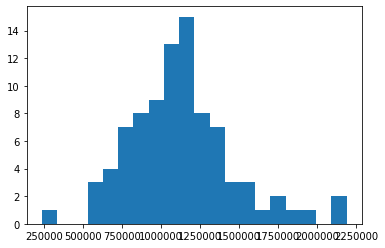

In [333]:
plt.hist(y_sal, bins=20)
plt.show()

In [258]:
pip install scipy 1.4.1

  ERROR: Could not find a version that satisfies the requirement 1.4.1 (from versions: none)
ERROR: No matching distribution found for 1.4.1
Note: you may need to restart the kernel to use updated packages.


In [260]:
pip install fancyimpute

Note: you may need to restart the kernel to use updated packages.


In [271]:
### making interaction for shuttle and weight/forty ###

In [288]:
shuttle_inter = df_with_dummies.dropna()[['weight','forty',]]

shuttle_inter["weight_dash"] = df_with_dummies.dropna()["weight"] * df_with_dummies.dropna()["forty"]

shuttle_inter= sm.add_constant(shuttle_inter)

interact_model_shuttle = sm.OLS(df_with_dummies.dropna()['shuttle'],shuttle_inter).fit()

interact_model_shuttle.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                shuttle   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     232.0
Date:                Thu, 16 Jan 2020   Prob (F-statistic):           3.94e-75
Time:                        14:31:14   Log-Likelihood:                 157.80
No. Observations:                 280   AIC:                            -307.6
Df Residuals:                     276   BIC:                            -293.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.2150      1.210      6.791      0.000       5.834      10.596
weight         -0.0184      0.004     -4.625      0.000      -0.026      -0.011
forty          -0.9846      0.270     -3.648      0.000      -1.516      -0.453
weight_dash     0.0045      0.001      5.215      0.000       0.003       0.006
==============================================================================
Omnibus:                        9.817   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.889
Skew:                           0.416   Prob(JB):                      0.00712
Kurtosis:                       3.392   Cond. No.                     1.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""